Step 1 — Load & Clean Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

# Upload file to Colab first (sidebar > Files > Upload)
file_path = "Hotel Bookings (1) (1) (1) (1).csv"
df = pd.read_csv(file_path)

# Clean
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
for col in ["children", "babies"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)
df = df.drop_duplicates()
df = df[df["adr"] >= 0]

# Feature engineering
df["total_stay_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
df["party_size"] = df["adults"] + df["children"] + df["babies"]

month_map = {
    "january":1,"february":2,"march":3,"april":4,"may":5,"june":6,
    "july":7,"august":8,"september":9,"october":10,"november":11,"december":12
}
df["arrival_date_month_num"] = df["arrival_date_month"].str.lower().map(month_map)

print("✅ Cleaned data shape:", df.shape)
df.head()


✅ Cleaned data shape: (87395, 35)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stay_nights,party_size,arrival_date_month_num
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Transient,0.0,0,0,Check-Out,2015-07-01,0,2.0,7
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Transient,0.0,0,0,Check-Out,2015-07-01,0,2.0,7
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,1.0,7
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,1.0,7
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,Transient,98.0,0,1,Check-Out,2015-07-03,2,2.0,7


Step 2 — When are bookings made?

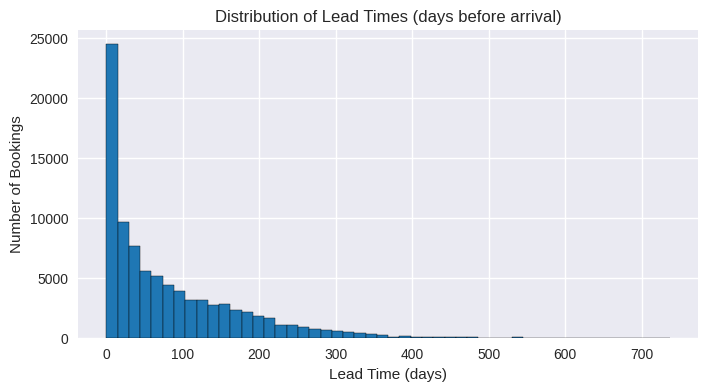

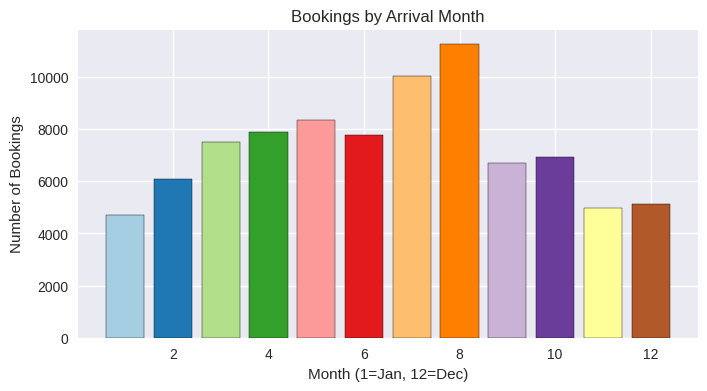

In [7]:
# Lead time distribution
plt.figure(figsize=(8,4))
plt.hist(df["lead_time"], bins=50, color="#1f77b4", edgecolor="black")
plt.title("Distribution of Lead Times (days before arrival)")
plt.xlabel("Lead Time (days)")
plt.ylabel("Number of Bookings")
plt.show()

# Bookings by month
monthly = df["arrival_date_month_num"].value_counts().sort_index()
plt.figure(figsize=(8,4))
colors = plt.cm.Paired(np.linspace(0,1,len(monthly)))
plt.bar(monthly.index, monthly.values, color=colors, edgecolor="black")
plt.title("Bookings by Arrival Month")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Number of Bookings")
plt.show()


Step 3 — Length of Stay vs ADR

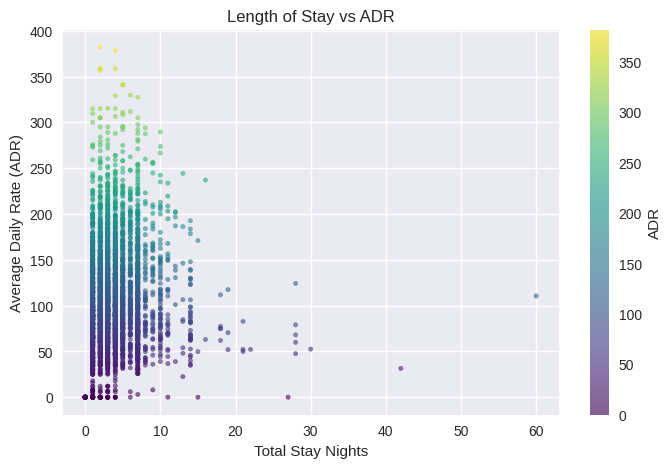

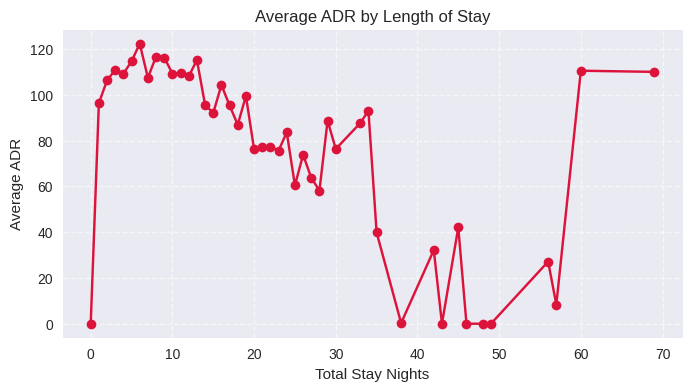

In [8]:
# Scatter (sampled for clarity)
sample = df[["total_stay_nights","adr"]].sample(5000, random_state=42)
plt.figure(figsize=(8,5))
plt.scatter(sample["total_stay_nights"], sample["adr"], c=sample["adr"], cmap="viridis", alpha=0.6, s=10)
plt.colorbar(label="ADR")
plt.title("Length of Stay vs ADR")
plt.xlabel("Total Stay Nights")
plt.ylabel("Average Daily Rate (ADR)")
plt.show()

# Average ADR by stay length
avg_adr = df.groupby("total_stay_nights")["adr"].mean()
plt.figure(figsize=(8,4))
plt.plot(avg_adr.index, avg_adr.values, marker="o", color="crimson")
plt.title("Average ADR by Length of Stay")
plt.xlabel("Total Stay Nights")
plt.ylabel("Average ADR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Step 4 — Special Requests

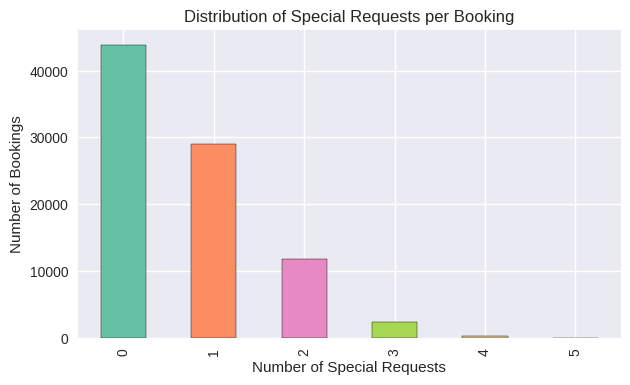

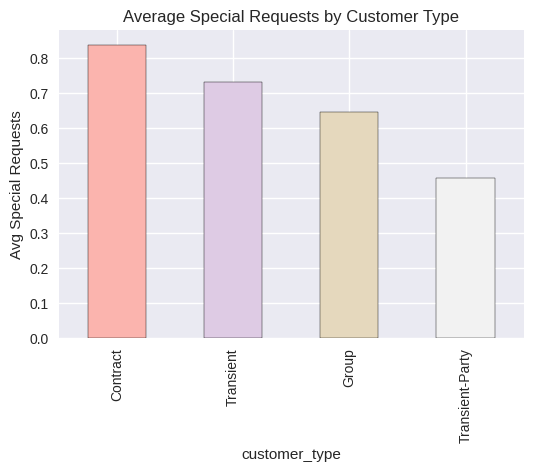

In [9]:
# Distribution
plt.figure(figsize=(7,4))
colors = plt.cm.Set2(np.linspace(0,1,df["total_of_special_requests"].nunique()))
df["total_of_special_requests"].value_counts().sort_index().plot(kind="bar", color=colors, edgecolor="black")
plt.title("Distribution of Special Requests per Booking")
plt.xlabel("Number of Special Requests")
plt.ylabel("Number of Bookings")
plt.show()

# Avg special requests by customer type
if "customer_type" in df.columns:
    reqs = df.groupby("customer_type")["total_of_special_requests"].mean().sort_values(ascending=False)
    reqs.plot(kind="bar", figsize=(6,4), color=plt.cm.Pastel1(np.linspace(0,1,len(reqs))), edgecolor="black")
    plt.title("Average Special Requests by Customer Type")
    plt.ylabel("Avg Special Requests")
    plt.show()


Step 5 — Demographic / Segment Effects

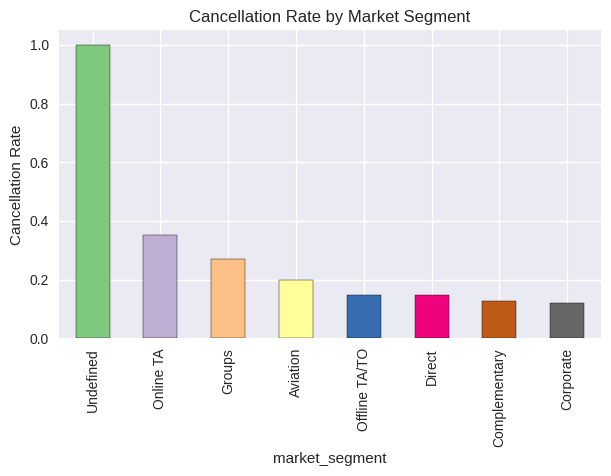

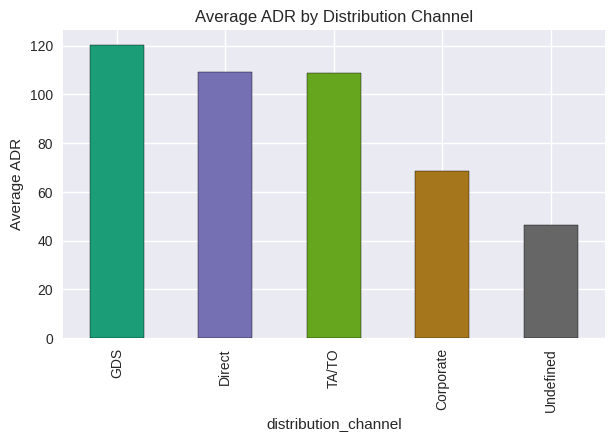

In [10]:
# Cancellation by market segment
if "market_segment" in df.columns:
    cancel_rate = df.groupby("market_segment")["is_canceled"].mean().sort_values(ascending=False)
    cancel_rate.plot(kind="bar", figsize=(7,4), color=plt.cm.Accent(np.linspace(0,1,len(cancel_rate))), edgecolor="black")
    plt.title("Cancellation Rate by Market Segment")
    plt.ylabel("Cancellation Rate")
    plt.show()

# ADR by distribution channel
if "distribution_channel" in df.columns:
    avg_adr_channel = df.groupby("distribution_channel")["adr"].mean().sort_values(ascending=False)
    avg_adr_channel.plot(kind="bar", figsize=(7,4), color=plt.cm.Dark2(np.linspace(0,1,len(avg_adr_channel))), edgecolor="black")
    plt.title("Average ADR by Distribution Channel")
    plt.ylabel("Average ADR")
    plt.show()


Step 6 — Business Insights

In [11]:
print("📊 Key Insights:")

# Prime booking time
median_lead = df["lead_time"].median()
print(f"- Median lead time before arrival: {median_lead:.0f} days")

# Ideal stay length
best_stay = df.groupby("total_stay_nights")["adr"].mean().idxmin()
print(f"- Lowest ADR is observed for stays of {best_stay} nights")

# Special requests
top_group = df.groupby("customer_type")["total_of_special_requests"].mean().idxmax()
print(f"- '{top_group}' customers make the most special requests")

# Cancellation risk
if "is_canceled" in df.columns:
    overall_cancel = df["is_canceled"].mean()
    print(f"- Overall cancellation rate: {overall_cancel:.2%}")


📊 Key Insights:
- Median lead time before arrival: 49 days
- Lowest ADR is observed for stays of 0 nights
- 'Contract' customers make the most special requests
- Overall cancellation rate: 27.49%
